# Principal Component Analysis
---

In this notebook, hand-written digit data from MNIST (Mixed National Institute of Standard and Technology) is analyzed. Principal Component Analysis (PCA) is performed for feature reduction, and K-Mean clustering algorithm is performed as an unsupervised learning method to recognize hand-written digit data.

This an exercise based on the Kaggle competition, "Digit-Recognizer".

https://www.kaggle.com/c/digit-recognizer

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
# set plot style
plt.style.use("ggplot")
sns.set_style("white")

In [3]:
# read train and test dataset
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# define X (features) and y (target)
X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]
X_test = df_test

In [4]:
df_train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


The training set consists of 42000 rows, each row representing a single training sample. There are 785 columns with first column representing label of hand-written digit (0-9) and the other columns representing pixel value (0-255)


##  Visualizing dataset

Since the goal of this analysis is to recognize hand-written digits, it is useful to visualize the dataset before we proceed.

- First, we slice the training dataframe so that only first n samples are chosen. 
- The sliced dataframe is reshaped so that we have an array of 28 x 28 matrix.
- array of matrix is plotted using Seaborn heatmap to visualize first n training samples.

In [6]:
# set number of samples to draw
n_samples = 25

# select first n samples from the training sample 
X_draw = X_train.iloc[:n_samples,:]

# reshape dataframe to array of 28 x 28 matrix
X_draw = X_draw.as_matrix().reshape(n_samples,28,28)

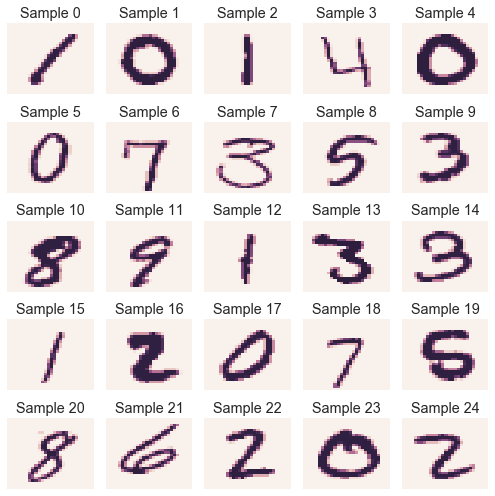

In [7]:
# create figure and axes
fig, ax = plt.subplots(5,5,figsize=(7,7))

for a, i in zip(ax.reshape(-1), range(n_samples)):
    
    # draw samples
    sns.heatmap(X_draw[i], ax=a, cbar=False)
    
    # customize plots
    a.set_title("Sample %s" %i)
    a.set_xticks([])
    a.set_yticks([])

# use tight layout
plt.tight_layout()

## Standardize dataset

Before perform PCA, the features are standardized $(x\rightarrow \frac{(x-\bar{x})}{\sigma})$ using Scikit StandardScaler. It is important to note that when we standardize the features, we need to use the statistics from the train dataset and apply them to both train and test datasets in order prevent information leak from the test dataset to the train dataset.

As you can see from 'describe' method, pixels have non-zero mean before standardization.

In [8]:
X_train.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [9]:
from sklearn.preprocessing import StandardScaler

# find scaler from training sample
scaler = StandardScaler().fit(X_train)

# standardize features
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Covariant matrix

In PCA, we change the basis of feature space in a way that maximizes variance of new features. Mathematically, this meanas that we need to first compute covariant matrix from the random varianbles, features. We use Numpy to compute such matrix.

After computing the covariant matrix, we can find eigenvectors and corresponding eigenvalues using Numpy.

In [10]:
# create covariant matrix from standardized X
cov_matrix = np.cov(X_train.T)

# find eigenvalues and eigenvectors of the covariant matrix
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

## Explained variance of new features

In this analysis, the original dataset has 784 features, and we need to decide how many features we want after feature reduction by PCA. In order to answer that question, we can plot cumulative explained variance by new features.

Explained variance of each feature (principal component) is defined by

- Eigenvalue of given feature / Total variance of all features

where total variance of all features can be calculated by

- Total variance = $\Sigma$ eigenvalues

In [11]:
# total variance 
total_var = np.sum(eig_vals)

# explained variance by each feature
exp_var = [x / total_var for x in sorted(eig_vals, reverse=True)]

# cumulative explained variance
cum_var = np.cumsum(exp_var)

(0, 300)

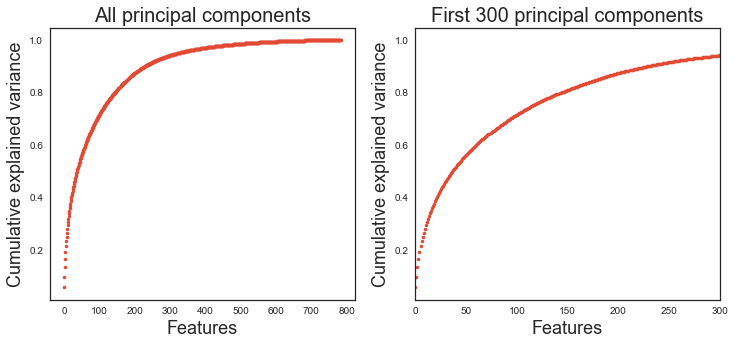

In [12]:
# define figure and axes
fig, ax = plt.subplots(1,2,figsize=(12,5))

# plot cumulative explained variance
ax[0].plot(cum_var, '.')
ax[1].plot(cum_var, '.')

# customize plot
for a in ax.reshape(-1):
    a.set_xlabel("Features", fontsize=18)
    a.set_ylabel("Cumulative explained variance", fontsize=18)

ax[0].set_title("All principal components", fontsize=20)
ax[1].set_title("First 300 principal components", fontsize=20)
ax[1].set_xlim([0,300])

The cumulative explained variance plot shows that the first 200 features can explain more than 80% of total variance. We decided to use the first 200 features from PCA for this analysis.

##  Visualizing eigenvectors (principal component)

In PCA, we extract new features from the existing feature set such that the new features would explain the most of variance of the given dataset. Once we decided to extract first n principal components from PCA (in this case, 200), it is informative to visualize the principal components and its explained variable, i.e. eigenvectors and eigenvalues.

For demostrative purpose, only first 25 principal components are drawn in the following plots.

In [13]:
from sklearn.decomposition import PCA

# set number of principal components to display
n_components = 200

# fit PCA with training data
pca = PCA(n_components=n_components).fit(X_train)
eig_vecs = pca.components_.reshape(n_components,28,28)

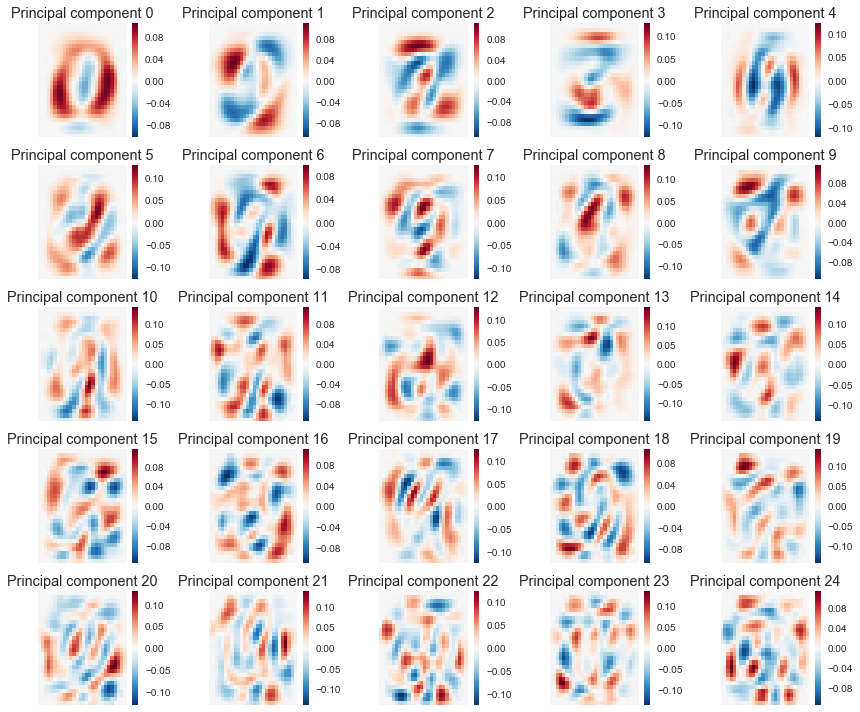

In [14]:
# create figure
fig, ax = plt.subplots(5,5,figsize=(12,10))

for a , i in zip(ax.reshape(-1), range(n_components)):
    
    # plot heatmap
    sns.heatmap(eig_vecs[i], ax =a)
    
    # customize plots
    a.set_title("Principal component %s" %i)
    a.set_xticks([])
    a.set_yticks([])

# use tight layout
plt.tight_layout()

The plots of principal components shows that the components with highest explained variance (eigenvalues) have simpler shape than the ones with smaller explained variance.

## Visualizing PCA representation

Given the new set of features from PCA, we can visualize the training sample in the new representation. In the previous section, PCA is already trained using the training sample with 200 principal component. Therefore, we only need to perform transformation on the training sample using the same PCA. 

Different colors are used for each label (0-9) so that we can visualize clusters within the scatter plot of first two principal components. 

In [15]:
# perform PCA on the training sample
X_train_PCA = pca.transform(X_train)

# select first two principal component of the training sample
X_train_PCA_1 = X_train_PCA[:,0]
X_train_PCA_2 = X_train_PCA[:,1]

# create DataFrame consists of first two principal components and target
df_PCA = pd.DataFrame({'PCA1':X_train_PCA_1,'PCA2':X_train_PCA_2,'target':y_train})

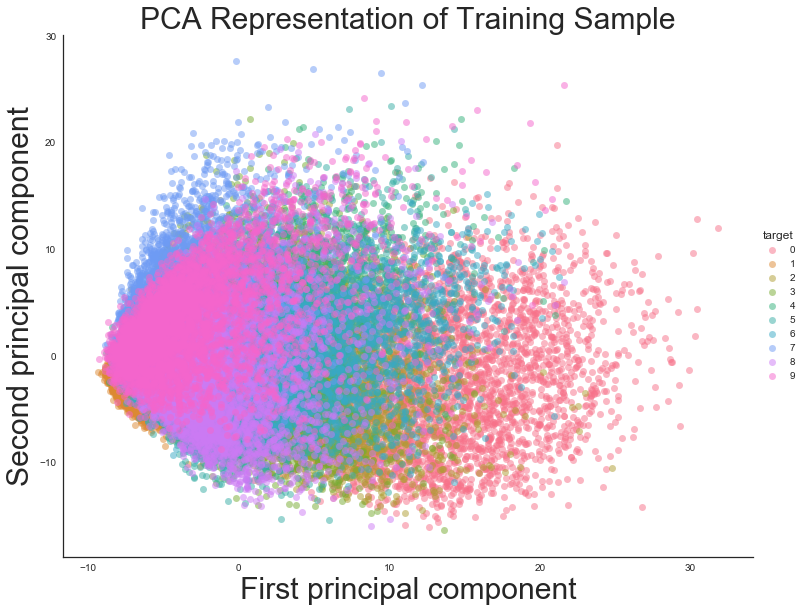

In [16]:
# make scatter plot
lm = sns.lmplot(x="PCA1", y="PCA2", data=df_PCA, hue="target", fit_reg=False, scatter_kws={"alpha":"0.5"}, size=8, aspect=1.3)

# customize plot
ax = plt.gca()
ax.set_title("PCA Representation of Training Sample", fontsize=30)
ax.set_xlabel("First principal component", fontsize=30)
ax.set_ylabel("Second principal component", fontsize=30)

We can see that training samples are clustered with the same label in the two dimensional scatter plot. Obviously, two principal components aren't sufficient enough to separate each clusters as they only accounts for 10% of the total variance.

## K-Mean Clustering for unsupervised learning

We performed PCA on the training samples and verified that we can reduce the number of features from 784 to 200 principal component while we retain more than 80% of the total variance. We can use this new representation (basis in linear algebra) to perform K-Mean clustering algorithm for unsupervised learning.

The idea of K-Mean clustering algorithm is very simple. Given $n$ number of clusters to form, the algorithm repeats the following process until it reaches equilibrium.
- Assign each sample to the cluster corresponding to its nearest centroid.
- Once all samples are assigned to one of clusters, calculate new means of the centroids in the feature space

**Important note**:
When performing PCA, we should not use the test samples for finding principal components in order to avoid any potential data leakage. This is true for all modeling decisions. Therefore, we need to use the same PCA object fitted using the training samples to transform the test samples. 

If we perform a separate PCA, we will use different princial components (axes) in test dataset, and we cannot correctly estimate the performance of K-mean clustering algorithm.

In [17]:
# perform PCA on the test dataset
X_test_PCA = pca.transform(X_test)

In [18]:
from sklearn.cluster import KMeans

# initiate K-mean cluster with 10 clusters
km = KMeans(n_clusters=10)

# train K-mean cluster with the training samples
km.fit(X_train_PCA)

# predict clusters of the test samples
y_predict_test = km.predict(X_test_PCA)

###  Clusters predicted

We used K-Mean clustering algorihtm to separate the test samples into 9 categories. Let's look at the distribution of these clusters.

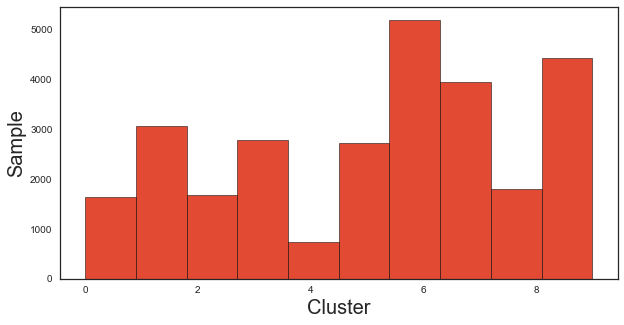

In [19]:
# define figure and axes
fig, ax = plt.subplots(figsize=(10,5))

# draw histogram
plt.hist(y_predict_test, edgecolor="black")

# customize plot
ax = plt.gca()
ax.set_xlabel("Cluster", fontsize=20)
ax.set_ylabel("Sample", fontsize=20)

The histogram shows that the predicted clusters aren't uniformly distributed. It is important to note that K-Mean clustering is an unsupervised learning algorithm. So the cluster numbers do not represent the labels for hand-written digits. 

## Visualizing PCA representation of predicted clusters

Given the predicted clusters from K-Mean clustering algorithm, it would be interesting to see the PCA representation of the clusters. For demostrative purpose, predicted clusters are plotted against the first two principal components of the test samples.

In [20]:
# select first two principal component of the test sample
X_test_PCA_1 = X_test_PCA[:,0]
X_test_PCA_2 = X_test_PCA[:,1]

# create DataFrame consists of first two principal components and target
df_PCA_test = pd.DataFrame({'PCA1':X_test_PCA_1,'PCA2':X_test_PCA_2,'predict':y_predict_test})

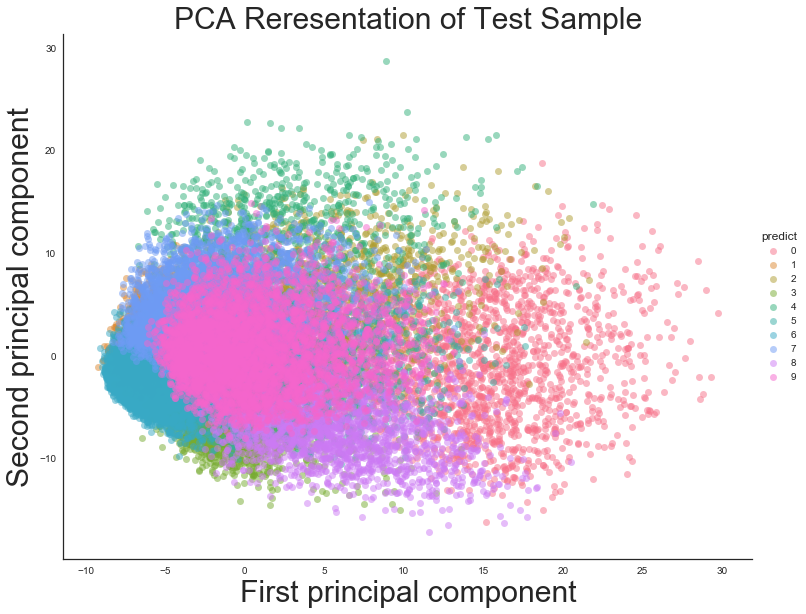

In [21]:
# make scatter plot
lm = sns.lmplot(x="PCA1", y="PCA2", data=df_PCA_test, hue="predict", fit_reg=False, scatter_kws={"alpha":"0.5"}, size=8, aspect=1.3)

# customize plot
ax = plt.gca()
ax.set_title("PCA Reresentation of Test Sample", fontsize=30)
ax.set_xlabel("First principal component", fontsize=30)
ax.set_ylabel("Second principal component", fontsize=30)

The scatter plot clearly shows that the predicted labels are nicely clustered in the principal component feature space.

Again, because K-Mean clustering algorithm is an unsupervised learning algorithm, the cluster numbers do not represent the labels of hand-written digits. 

##  Conclusion

The purpose of this analysis is to learn the method of feature reduction using the PCA and K-mean clustering algorihtm as an unsupervised learning. The following ideas were discussed and performed in this anlaysis.

From the PCA,
- Standardization of samples before performing PCA
- Finding eigenvectors and eigenvalues of covariant matrix
- Estimating total and individual explained variance of principal components
- Finding principal component using the training sample and transforming the test samples using the same principal components

From K-Mean clustering algorithm,
- Performing K-mean clustering algorithm on the principal component representation of the test samples
- Principal component representation of the predicted clusters